<a href="https://colab.research.google.com/github/daquinterop/gee_notebooks/blob/main/Phenology_maps_zimbabwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='servir-sco-assets')

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

In [ ]:
# Just testing that geemap and ipyleaflet is working
boundary = (
    ee.FeatureCollection("FAO/GAUL/2015/level0")
    .filter(ee.Filter.eq("ADM0_NAME", "Zimbabwe"))
)
envelope = boundary.geometry().bounds()
# m = geemap.Map(height=400)
# m.add_ee_layer(boundary)
# display(m)

In [ ]:
def get_year_collection(year):
  year = ee.Number(year)
  start_date = year.format().cat('-06-01')
  end_date = year.add(1).format().cat('-10-31')
  dataset = (
      ee.ImageCollection('MODIS/061/MOD13Q1')
      .filterBounds(envelope)
      .filter(ee.Filter.date(start_date, end_date)) # We know that in zimbabwe the SOS is arround November
      .select("NDVI")
      .map(
        lambda image: image.addBands( # Adds a band with the number of day since the start of that year
        ee.Image.constant(
          ee.Date(image.get("system:time_start"))
          .getRelative('day', 'year').add(9) # Add 9 since the image is based in a 16 day composite
          .add(
            ee.Date(image.get("system:time_start")).get("year")
            .subtract(year).multiply(365)
          )
        ).rename(["t"]).float()
      )
    )
  )
  return dataset

year_collection = get_year_collection(2020)

## Harmonic model

$p_t = \beta_0 + A_0cos(2\pi\omega_0 t - \phi_0) + A_1cos(2\pi\omega_1 t - \phi_1) e_t$

$p_t = \beta_0 + \beta_1cos(2\pi\omega_0 t) + \beta_2sin(2\pi\omega_0 t) + \beta_3cos(2\pi\omega_1 t) + \beta_4sin(2\pi\omega_1 t) + e_t$

$\omega_0=1; \omega_1=0.5$

In [ ]:
def add_harmonic_variables(image):
  image = image.addBands(ee.Image.constant(1))
  timeRadians = image.select('t').divide(365).multiply(2 * np.pi)
  image = image.addBands(timeRadians.cos().rename('cos1'))
  image = image.addBands(timeRadians.sin().rename('sin1'))
  image = image.addBands(timeRadians.divide(2).cos().rename('cos2'))
  image = image.addBands(timeRadians.divide(2).sin().rename('sin2'))
  return image

def fit_harmonic_model(collection):
  harmonic_independents = ee.List(['constant', 'cos1', 'sin1', 'cos2', 'sin2']);
  dependent = ee.String('NDVI')
  harmonic = collection.map(add_harmonic_variables)

  harmonic_fit = (
    harmonic
    .select(harmonic_independents.add(dependent))
    .reduce(
      ee.Reducer.linearRegression(**{ # The output of this reducer is a 3x1 array image.
        "numX": harmonic_independents.length(),
        "numY": 1
      })
    )
  )
  # Turn the array image into a multi-band image of coefficients.
  harmonic_coefficients = (
    harmonic_fit.select('coefficients')
    .arrayProject([0])
    .arrayFlatten([harmonic_independents])
  )
  # Compute fitted values.
  # fittedHarmonic = harmonicInds.map(lambda img:
  fitted_harmonic = harmonic.map(lambda image:
    image.addBands(
      image.select(harmonic_independents)
      .multiply(harmonic_coefficients)
      .reduce('sum')
      .rename('fitted')
    )
  )
  return fitted_harmonic

In [ ]:
fitted_harmonic = fit_harmonic_model(year_collection)

In [ ]:
df_fitted = pd.DataFrame.from_records([
    feature["properties"] for feature in
    fitted_harmonic.map(
        lambda image: image.sample(ee.Geometry.Point(32.37, -20.18)).first()
    ).getInfo()["features"]
])
df_fitted.index = [datetime(2000, 1, 1) + timedelta(i) for i in df_fitted['t']]
df_fitted = df_fitted.sort_index()

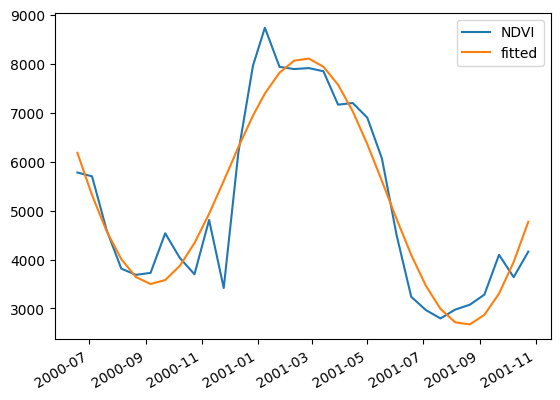

In [ ]:
ax = df_fitted.NDVI.plot(label="NDVI")
df_fitted.fitted.plot(ax=ax, label="fitted")
ax.legend()

## Start of the season following FAO WaPOR metodology

[VanHoolst et. al. (2016)](https://www.researchgate.net/publication/290315408_FAO's_AVHRR-based_Agricultural_Stress_Index_System_ASIS_for_global_drought_monitoring) define the start of the season (SOS) as the moment when the rising vegetation index (VI) curve meets the threshold $VI_{sos}$, and the end of season (EOS) as the date when the descending curve meets $VI_{eos}$, see figure:

$VI_{sos} = (VI)_{min,sos} + T_{sos} ((VI)_{max}-(VI)_{min,sos})$

$VI_{eos} = (VI)_{min,eos} + T_{eos}\times((VI)_{max}-(VI)_{min,eos})$

![Growing season description](https://www.researchgate.net/profile/Roel-Van-Hoolst/publication/290315408/figure/fig9/AS:325357564645389@1454582696683/De-fi-nition-of-the-start-and-end-of-the-growing-season-SOS1-EOS1-from-the-NDVI-pro-fi.png)

where $VI_{max}$ is the $VI$ at the maximum of the cycle and $VI_{min,sos}$ and $VI_{min,eos}$ the values of the surrounding minima. SOS is searched leftwards from $VI_{max}$ to $VI_{min,sos}$, EOS rightwards from $VI_{max}$ to $VI_{min,eos}$. $T_{sos}$ and $T_{eos}$ are modifiable and were fixed to 0.25 and 0.75 respectively.

In [ ]:
def get_min_max_time_image(fitted_harmonic):
  axes = {"image": 0, "band": 1}

  # First find the max NDVI
  array = fitted_harmonic.select(["fitted", 't']).toArray()
  sort = array.arraySlice(axes["band"], 0, 1) # Select fitted NDVI band
  sorted = array.arraySort(sort) # Sort by fitted NDVI values
  length = sorted.arrayLength(axes['image'])
  values_max = sorted.arraySlice(axes['image'], length.subtract(1), length) # Selecting last image (max fitted)
  max_image = values_max.arrayProject([axes["band"]]).arrayFlatten([['fitted', 't']])
  time_max = max_image.select('t') # Image with the time of max NDVI

  # Mask out all values after the max NDVI
  fitted_harmonic_before_max = fitted_harmonic.map(
      lambda image: image.updateMask(image.select("t").lt(time_max))
  )
  array = fitted_harmonic_before_max.select(["fitted", 't']).toArray()
  sort = array.arraySlice(axes["band"], 0, 1) # Select fitted NDVI band
  sorted = array.arraySort(sort) # Sort by fitted NDVI values
  values_min = sorted.arraySlice(axes["image"], 0, 1) # Selecting first image (min fitted)
  minsos_image = values_min.arrayProject([axes["band"]]).arrayFlatten([['fitted', 't']])

  # Mask out all values after the max NDVI
  fitted_harmonic_after_max = fitted_harmonic.map(
      lambda image: image.updateMask(image.select("t").gt(time_max))
  )
  array = fitted_harmonic_after_max.select(["fitted", 't']).toArray()
  sort = array.arraySlice(axes["band"], 0, 1) # Select fitted NDVI band
  sorted = array.arraySort(sort) # Sort by fitted NDVI values
  values_min = sorted.arraySlice(axes["image"], 0, 1) # Selecting first image (min fitted)
  mineos_image = values_min.arrayProject([axes["band"]]).arrayFlatten([['fitted', 't']])

  image = max_image.addBands(minsos_image).addBands(mineos_image).rename(
      ["max_val", "max_time", "minsos_val", "minsos_time", "mineos_val", "mineos_time"]
  )
  return image

max_min_image = get_min_max_time_image(fitted_harmonic)

In [ ]:
max_min_image.reduceRegion(
    ee.Reducer.min(),
    geometry=boundary.geometry()
).getInfo(),

({'max_time': 422,
  'max_val': 5183.238043908106,
  'mineos_time': 598,
  'mineos_val': 2423.8816390477295,
  'minsos_time': 233,
  'minsos_val': 1904.547614648475},)

In [ ]:
max_min_image.reduceRegion(
    ee.Reducer.max(),
    geometry=boundary.geometry()
).getInfo()

{'max_time': 454,
 'max_val': 7218.635150878522,
 'mineos_time': 630,
 'mineos_val': 4599.438356245922,
 'minsos_time': 265,
 'minsos_val': 4252.122647090947}

In [ ]:
palette = [
    mpl.colors.to_hex(mpl.colormaps.get("hsv")((i+.5)/12))
    for i in range(0, 12)
]
ndviVis = {
  "min": 0,
  "max": 8000,
  "palette": [
    'ffffff', 'ce7e45', 'df923d', 'f1b555', 'fcd163', '99b718', '74a901',
    '66a000', '529400', '3e8601', '207401', '056201', '004c00', '023b01',
    '012e01', '011d01', '011301'
  ],
}
m = geemap.Map(basemap='HYBRID', height=600)
m.addLayer(
    max_min_image.select("minsos_time").clip(boundary),
     {"min": 0, "max": 365, "palette": palette},
    "Min SOS time"
)
m.addLayer(
    max_min_image.select("max_time").clip(boundary),
     {"min": 365, "max": 2*365, "palette": palette},
    "Max time"
)
m.addLayer(
    max_min_image.select("mineos_time").clip(boundary),
     {"min": 365, "max": 2*365, "palette": palette},
    "Min EOS time"
)

m.addLayer(
    max_min_image.select("minsos_val").clip(boundary), ndviVis, "Min SOS Value"
)
m.addLayer(
    max_min_image.select("max_val").clip(boundary), ndviVis, "Max Value"
)
m.addLayer(
    max_min_image.select("mineos_val").clip(boundary), ndviVis, "Min EOS Value"
)

m.add_legend(
    keys=[datetime(2000, i+1, 1).strftime("%b") for i in range(0, 12)],
    colors=palette,
    position="bottomleft"
)
display(m)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
def get_season_image(fitted_harmonic):
  max_min_image = get_min_max_time_image(fitted_harmonic)
  tmin_sos = max_min_image.select("minsos_time")
  vimin_sos = max_min_image.select("minsos_val")
  tmax = max_min_image.select("max_time")
  vimax = max_min_image.select("max_val")
  tmin_eos = max_min_image.select("mineos_time")
  vimin_eos = max_min_image.select("mineos_val")

  vi_sos = vimin_sos.add(
      ee.Image(vimax.subtract(vimin_sos)).multiply(0.25)
  )
  vi_eos = vimin_eos.add(
      ee.Image(vimax.subtract(vimin_sos)).multiply(0.75)
  )

  # Produce SOS image
  vi_diff = fitted_harmonic.map(
    lambda image:
    image.addBands(
      image.select("fitted").subtract(vi_sos.select(0)).abs()
      .rename(["vi_diff"])
    ).updateMask(
      image.select("t").gt(tmin_sos)
    ).updateMask(
      image.select("t").lt(tmax)
    )
  )
  axes = {"image": 0, "band": 1}
  array = vi_diff.select(["vi_diff", 't']).toArray()
  sort = array.arraySlice(axes["band"], 0, 1)
  sorted = array.arraySort(sort)
  vi_diff_min = sorted.arraySlice(axes["image"], 0, 1)
  sos_image = vi_diff_min.arrayProject([axes["band"]]).arrayFlatten([['vi_diff', 'sos']])
  sos_image = sos_image.select("sos")

  # Produce EOS image
  vi_diff = fitted_harmonic.map(
    lambda image:
    image.addBands(
      image.select("fitted").subtract(vi_eos.select(0)).abs()
      .rename(["vi_diff"])
    ).updateMask(
      image.select("t").gt(tmax)
    ).updateMask(
      image.select("t").lt(tmin_eos)
    )
  )
  axes = {"image": 0, "band": 1}
  array = vi_diff.select(["vi_diff", 't']).toArray()
  sort = array.arraySlice(axes["band"], 0, 1)
  sorted = array.arraySort(sort)
  vi_diff_min = sorted.arraySlice(axes["image"], 0, 1)
  eos_image = vi_diff_min.arrayProject([axes["band"]]).arrayFlatten([['vi_diff', 'eos']])
  eos_image = eos_image.select("eos")

  image = sos_image.addBands(eos_image)
  image = image.addBands(eos_image.subtract(sos_image).rename(["los"]))
  return image

In [ ]:
season = get_season_image(fitted_harmonic)

In [ ]:
m = geemap.Map(basemap='HYBRID', height=600)
m.addLayer(
    season.select("sos").clip(boundary),
    {"min": 0, "max": 365, "palette": palette}, "SOS"
)
m.addLayer(
    season.select("eos").subtract(365).clip(boundary),
    {"min": 0, "max": 365, "palette": palette}, "EOS"
)
m.addLayer(
    season.select("los").clip(boundary),
    {"min": 50, "max": 300, "palette": ["#FF0000", "#00FF00"]}, "LOS"
)
display(m)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

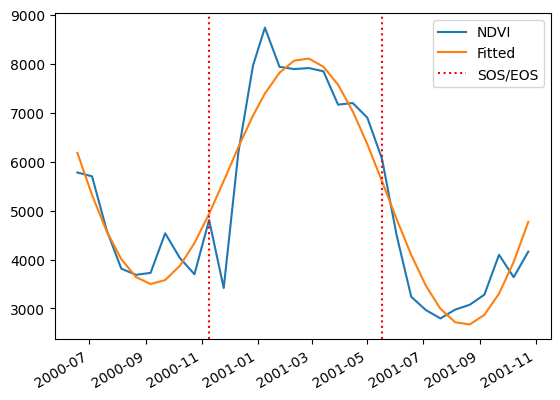

In [ ]:
ax = df_fitted.NDVI.plot(label="NDVI")
df_fitted.fitted.plot(ax=ax, label="Fitted")
season_dict = season.sample(ee.Geometry.Point(32.37, -20.18)).getInfo()['features'][0]["properties"]
sos_value = datetime(2000, 1, 1) + timedelta(season_dict["sos"])
ax.axvline(sos_value, color="red", linestyle=":", label="SOS/EOS")
eos_value = datetime(2000, 1, 1) + timedelta(season_dict["eos"])
ax.axvline(eos_value, color="red", linestyle=":")
ax.legend()

In [ ]:
def get_season_for_year(year):
    collection = get_year_collection(year)
    fitted_harmonic = fit_harmonic_model(collection)
    sos_image = get_season_image(fitted_harmonic)
    sos_image = sos_image.set("year", year)
    return sos_image

season_collection = ee.ImageCollection(
    ee.List(list(range(2011, 2024))).map(get_season_for_year)
)

In [ ]:
# sos_collection.map(lambda image: image.reduceRegion(ee.Reducer.mean()))

In [ ]:
m = geemap.Map(basemap='HYBRID', height=600)
for year in range(2011, 2023):
  m.addLayer(
      season_collection.filter(ee.Filter.eq('year', year)).select("sos").first().clip(boundary),
      {"min": 0, "max": 365, "palette": palette},
      f"{year} sos"
  )

m.add_legend(
    keys=[datetime(2000, i+1, 1).strftime("%b") for i in range(0, 12)],
    colors=palette,
    position="bottomleft"
)
display(m)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Crop masks
landcover = ee.ImageCollection('MODIS/061/MCD12Q1')
igbpLandCover = (
    landcover.select('LC_Type1')
    .filter(ee.Filter.eq('system:index', '2021_01_01'))
    .first()
)

igbpSuitableForCrops = (
    igbpLandCover.updateMask(
      igbpLandCover.lte(5).Not() # Forests
      .And(igbpLandCover.eq(11).Not()) # Permanent wetlands
      # // .and(igbpLandCover.eq(7).not()) // Closed Shrublands
      # // .and(igbpLandCover.eq(6).not()) // Open Shrublands
      .And(igbpLandCover.eq(13).Not())# Urban
      .And(igbpLandCover.gte(15).Not()) #Snow, Barren and Water
  ).gt(0)
  # .unmask();
)
igbpCroplands = igbpLandCover.updateMask(
  igbpLandCover.eq(12).Or(igbpLandCover.eq(14))
)

igbpCroplands = igbpCroplands.gt(0).rename("cropland")

In [ ]:
sos_average = season_collection.select("sos").mean()

m = geemap.Map(basemap='HYBRID', height=600)
m.addLayer(
    sos_average.updateMask(igbpSuitableForCrops).clip(boundary),
    {"min": 0, "max": 365, "palette": palette}, "Average SOS"
)
m.add_legend(
    keys=[datetime(2000, i+1, 1).strftime("%b") for i in range(0, 12)],
    colors=palette,
    position="bottomleft"
)
display(m)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
task = ee.batch.Export.image.toDrive(**{
    "image": sos_average.mask(igbpCroplands),
    "fileNamePrefix" : "zimbabwe_modis_sos_croplands",
    "region": boundary.geometry(),
    # "scale": 10000,
    "crsTransform": [0.1, 0, 179.95, 0, -0.1, 89.95],
    "crs": 'EPSG:4326',
    "folder": 'gee_exports'
 })
task.start()

task = ee.batch.Export.image.toDrive(**{
    "image": sos_average.mask(igbpSuitableForCrops),
    "fileNamePrefix" : "zimbabwe_modis_sos_cropSuitable",
    "region": boundary.geometry(),
    # "scale": 10000,
    "crsTransform": [0.1, 0, 179.95, 0, -0.1, 89.95],
    "crs": 'EPSG:4326',
    "folder": 'gee_exports'
 })
task.start()